# References

https://www.kaggle.com/humamfauzi/btc-price-prediction-using-lstm

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

https://www.analyticsvidhya.com/blog/2021/05/bitcoin-price-prediction-using-recurrent-neural-networks-and-lstm/

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation

In [36]:
# Change...
pair = 'BTCUSDT'

# interval used to compute indicators and backtest analysis
# valid intervals - 1min, 3min, 5min, 15min, 30min, 1H, 2H, 4H, 6H, 8H, 12H, 1D, 3D, 1W, 1M
interval = '1H'

In [37]:
from trade_utils import get_data

data = get_data(pair, interval)

In [38]:
# Last column must be the target
COLUMNS = ['ClosePrice']
N_STEPS = 90
N_FEATURES = len(COLUMNS)

data = data[COLUMNS].copy()

In [39]:
from machine_learning_utils import split_sequence

sc = MinMaxScaler()
data_scaled = sc.fit_transform(data)

In [40]:
#close_price = np.array(data['ClosePrice']).reshape(-1,1)
#close_price = np.array(data.iloc[:,-1]).reshape(-1,1)
#close_price

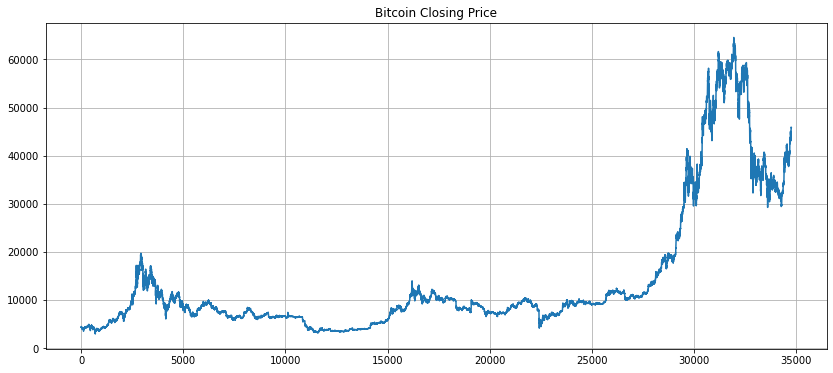

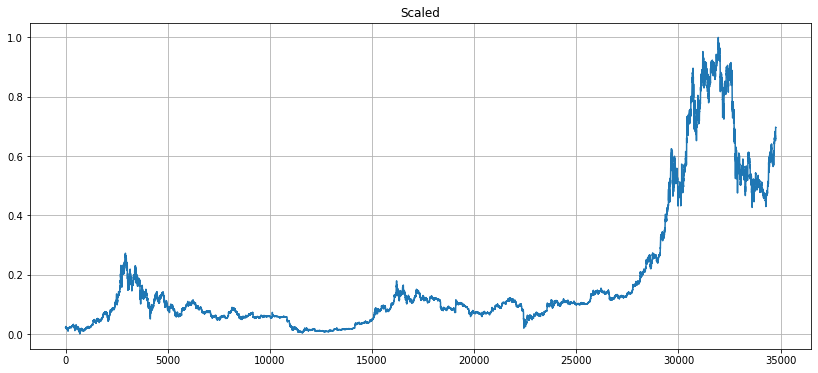

In [41]:
close_price = np.array(data['ClosePrice']).reshape(-1,1)
plt.figure(figsize=(14,6))
plt.title("Bitcoin Closing Price")
plt.grid()
plt.plot(close_price)

# Last column from data_scaled
close_price_scaled = data_scaled[:,-1]
plt.figure(figsize=(14,6))
plt.title("Scaled")
plt.grid()
plt.plot(close_price_scaled)

In [42]:
from machine_learning_utils import split_sequence

X, y = split_sequence(data_scaled, N_STEPS)
print(X.shape, y.shape)

(34673, 90, 1) (34673,)


In [43]:
# Obtain the features and target for the 'train_data' and 'test_data' without shuffling
# shuffle is not correct to use in time-series analysis because the order of the data is mandatory
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, shuffle=False)

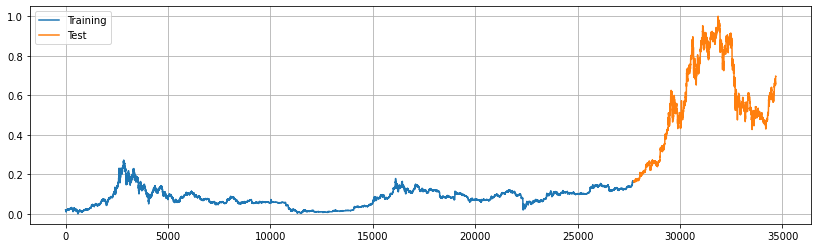

In [44]:
plt.figure(figsize=(14,4))
plt.plot(range(len(y_train)), y_train)
plt.plot(range(len(y_train), len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()

## Prepare X for LSTM

In [45]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], N_FEATURES))
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], N_FEATURES))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 90, 50)            10400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 90, 50)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 90, 50)            20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 90, 50)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

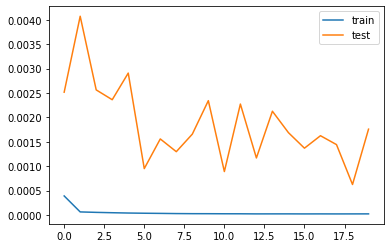

CPU times: user 42min 43s, sys: 2min 21s, total: 45min 5s
Wall time: 18min 22s


In [46]:
%%time
# define model
model = Sequential()

# LSTM layer 1
model.add(LSTM(units = 50, return_sequences=True, input_shape=(N_STEPS, N_FEATURES)))
model.add(Dropout(0.2))

# Intermediate LSTM layer
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))

# LSTM layer
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Fully connected layer
model.add(Dense(units = 1))

print(model.summary())

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting to the training set
history = model.fit(X_train, y_train, epochs=20, batch_size=200, validation_data=(X_test, y_test))

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [47]:
y_pred = model.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)

Text(0, 0.5, 'Price')

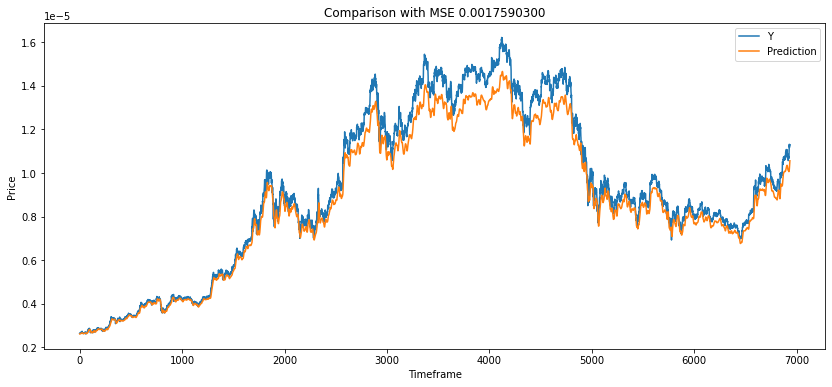

In [48]:
# scale used in last column (target)
scale_target = sc.scale_[-1]

plt.figure(figsize=(14,6))
plt.plot(y_test * scale_target)
plt.plot(y_pred * scale_target)
plt.title("Comparison with MSE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")